Populating the interactive namespace from numpy and matplotlib
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Step 1: Minibatch Loss: 334.574524
Step 1000: Minibatch Loss: 222.938812
Step 2000: Minibatch Loss: 214.714157
Step 3000: Minibatch Loss: 219.943573
Step 4000: Minibatch Loss: 239.257538
Step 5000: Minibatch Loss: 232.204788
Step 6000: Minibatch Loss: 227.091827
Step 7000: Minibatch Loss: 226.118256
Step 8000: Minibatch Loss: 196.333466
Step 9000: Minibatch Loss: 217.870270
Step 10000: Minibatch Loss: 224.747635
Step 11000: Minibatch Loss: 226.770584
Step 12000: Minibatch Loss: 218.979614
Step 13000: Minibatch Loss: 225.183441
Step 14000: Minibatch Loss: 232.086060
Step 15000: Minibatch Loss: 219.505371
Step 16000: Minibatch Loss: 224.196487
Step 17000: Minibatch Loss: 194.221954

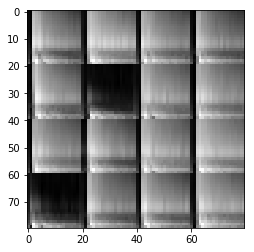

Reconstructed Images


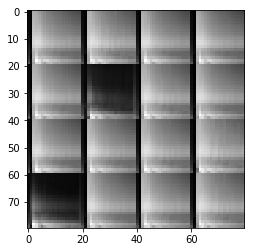

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
import os

%pylab inline

image_width=20

pwd = os.getcwd()
tfrecord_file_path = pwd + "/VAE_input.tfrecord"
filename_queue = tf.train.string_input_producer(
                              tf.train.match_filenames_once(tfrecord_file_path),
                              shuffle=True, num_epochs=None)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(serialized_example,
                                       features={'data': tf.FixedLenFeature([], tf.string)}) 
img = tf.decode_raw(features['data'], tf.uint8)
img = tf.image.convert_image_dtype(img,tf.float32)
img = tf.reshape(img, [image_width * image_width])
input_batch = tf.train.shuffle_batch([img],batch_size=20,capacity=500,min_after_dequeue=250,num_threads=1)    
    
# Parameters
learning_rate = 0.001
num_steps = 40000
display_step = 1000

# Network Parameters
image_dim = image_width * image_width
hidden_dim = 512
latent_dim = 2

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim],name='input_x')
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)


# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

saver = tf.train.Saver()
tf.add_to_collection('output_y', decoder)
tf.add_to_collection('output_y', loss_op) 

with tf.Session() as sess:
    
    tf.local_variables_initializer().run()
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    for i in range(1,num_steps+1):
        _, l = sess.run([train_op, loss_op],feed_dict={input_image: input_batch.eval()})
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            
    saver.save(sess,'saver/VAE/VAE')

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((image_width * n, image_width * n))
    canvas_recon = np.empty((image_width * n, image_width * n))
    for i in range(n):
        # MNIST test set
        batch_x = input_batch.eval()
        # Encode and decode the digit image
        g = sess.run(decoder, feed_dict={input_image : batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * image_width:(i + 1) * image_width, j * image_width:(j + 1) * image_width] = \
                batch_x[j].reshape([image_width, image_width])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * image_width:(i + 1) * image_width, j * image_width:(j + 1) * image_width] = \
                g[j].reshape([image_width, image_width])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()
    
    coord.request_stop()
    coord.join(thread)